In [1]:
%matplotlib notebook
import flux

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
nside = 128

theta, phi = hp.pix2ang(nside,np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
J = flux.stokes.spline_beam_func(150e6, alt, az)
J_abs = np.abs(J)

In [4]:
print('HERA latitude:', flux.rot.hera_lat)
print('HERA longitude:', flux.rot.hera_lon)
print('Current LST in radians:', flux.rot.get_lst())

HERA latitude: -30.72138888888889
HERA longitude: 21.428333333333335
Current LST in radians: 5.594151635819595


In [5]:
lst_now_deg = np.degrees(flux.rot.get_lst())
az, alt = flux.rot.eq_to_topo(lst_now_deg, flux.rot.hera_lat, flux.rot.hera_lat, lst_now_deg)
print('With right ascension = LST and declination = HERA latitude, we have:')
print('Azimuth:', az, 'altitude:', alt)
# the azimuth is going to land all over the place, but it is okay:
# because we are working at zenith, azimuth becomes meaningless

With right ascension = LST and declination = HERA latitude, we have:
Azimuth: 45.0 altitude: 90.0


In [6]:
def rad_interp(J_section, az, alt):
    """
    Abbreviation and conversion function. We get the interpolation value
    assuming @az and @alt are in degrees.
    """
    colatitude = np.radians(90 - alt)
    longitude = np.radians(az)
    return hp.get_interp_val(J_section, colatitude, longitude)

In [7]:
# This is an old brute force technique which is interesting
# but no longer of any manifest utility.
colatitude_range = np.radians(np.linspace(0, 180, 20))
longitude_range = np.radians(np.linspace(-180, 180, 40))
# Yes, we are only doing 20 x 40 points. This thing EATS CPU!
def maximize(J_section):
    current_max = [0, 0, 0] # this is bad practice but we already know the maximum is greater than one
    for col in colatitude_range:
        for lon in longitude_range:
            ev = hp.get_interp_val(J_section, col, lon)
            if ev > current_max[0]:
                current_max[0] = ev
                current_max[1] = col
                current_max[2] = lon
    return current_max
# Of course, this approach will not be very helpful anyway because the maximum might span an area...

In [8]:
print(maximize(J_abs[:, 1, 0]))
# Failure!! How did that even happen?
print(maximize(J_abs[:, 0, 0]))

[0.9981647450856115, 0.0, -3.141592653589793]
[0.05959529562036919, 0.16534698176788384, -0.8860902356278905]


In [9]:
# :: xy and yx are just leakage terms; they are not beam response terms
# in other words, the maximum response can occur at any point, and it is okay that these do not maximize.

print(rad_interp(J_abs[:, 1, 0], az, alt)) # true maximum: .998166
print(rad_interp(J_abs[:, 0, 0], az, alt)) # ": .0624716
print(rad_interp(J_abs[:, 0, 1], az, alt)) # ": .998166
print(rad_interp(J_abs[:, 1, 1], az, alt)) # ": .0624716

0.9981647450856115
0.002676887226695273
0.9981647531755684
0.002677818315750198


In [10]:
az_neigh = np.linspace(az - 20, az + 20, 1000)
az_const = np.full(1000, az)

alt_neigh = np.linspace(alt - 20, alt + 20, 1000)
alt_const = np.full(1000, alt)

In [11]:
def response_plot(label, section):
    fig, ax = flux.demo.frame()
    plt.title(label + ' varying altitude about ' + str(round(alt, 1)) + '$^\circ$')
    ax.plot(alt_neigh, rad_interp(section, az_const, alt_neigh))
    plt.ylabel('Response [0, 1]', fontsize=12)
    plt.xlabel('Altitude [$^\circ$]')
    plt.show()
    
    fig, ax = flux.demo.frame()
    plt.title(label + ' varying azimuth about ' + str(round(az, 1)) + '$^\circ$')
    ax.plot(az_neigh, rad_interp(section, az_neigh, alt_const))
    plt.ylabel('Response [0, 1]', fontsize=12)
    # I have to force this y window if I want the axis to look reasonable.
    plt.ylim((0, 1.1))
    plt.xlabel('Azimuth [$^\circ$]')
    plt.show()

<IPython.core.display.Javascript object>


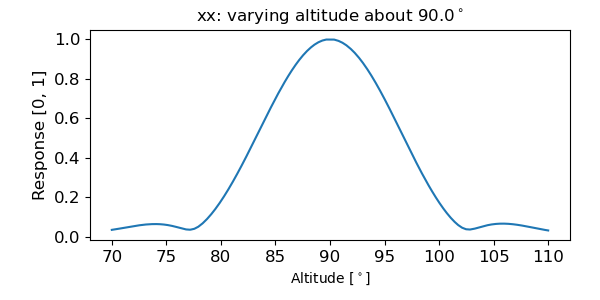

<IPython.core.display.Javascript object>


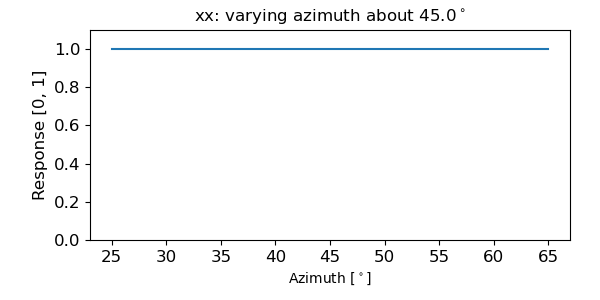

In [12]:
# The lower plot shows that azimuth has no impact near zenith.
response_plot('xx:', J_abs[:, 1, 0])

<IPython.core.display.Javascript object>


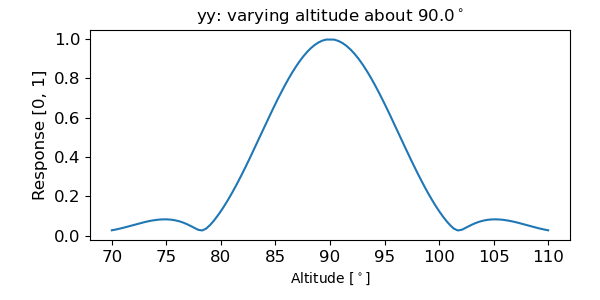

<IPython.core.display.Javascript object>


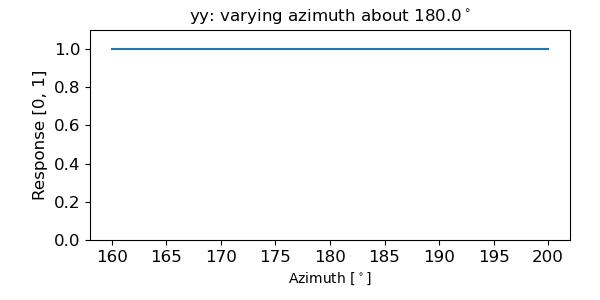

In [15]:
# These plots look pretty much identical to the xx
response_plot('yy:', J_abs[:, 0, 1])

<IPython.core.display.Javascript object>


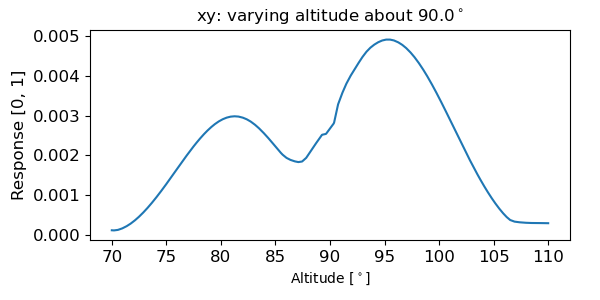

<IPython.core.display.Javascript object>


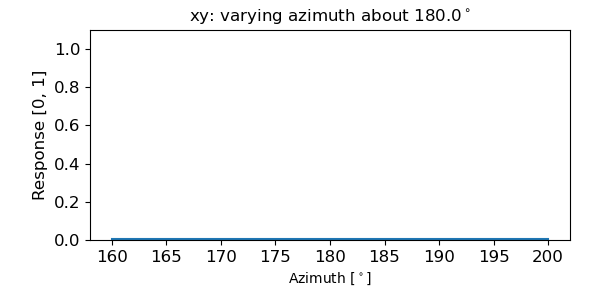

In [16]:
# Not particularly relevant (these are leakage plots), but interesting
response_plot('xy:', J_abs[:, 0, 0])

<IPython.core.display.Javascript object>


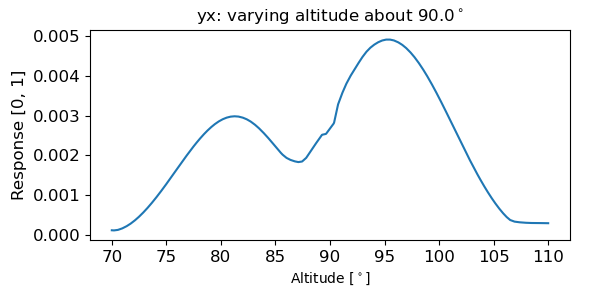

<IPython.core.display.Javascript object>


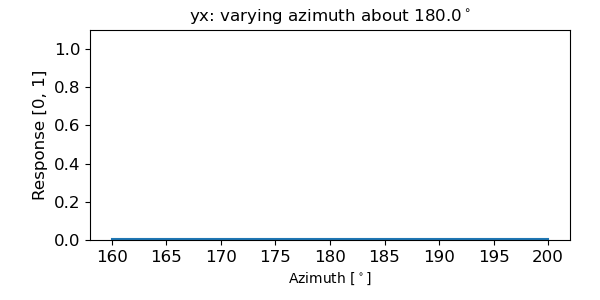

In [17]:
# Not particularly relevant (these are leakage plots), but interesting
response_plot('yx:', J_abs[:, 0, 0])